<a href="https://colab.research.google.com/github/Niharika-Saha/Adaptive-Bacterial-Antibiotic-Resistance-Prediction-using-Meta-Learning/blob/experiments/exp1_bayesian_metaoptnet_megares_to_ndaro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Load and explore NDARO dataset files
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Load NDARO data files
print("Loading label_map.csv...")
label_map = pd.read_csv("label_map.csv")  # adjust path if needed
print("Label map columns:", label_map.columns.tolist())
print("Label map shape:", label_map.shape)
print("\nFirst few rows of label_map:")
print(label_map.head())

print("\n" + "="*50)

print("Loading seq_manifest.csv...")
seq_manifest = pd.read_csv("seq_manifest.csv")  # adjust path if needed
print("Sequence manifest columns:", seq_manifest.columns.tolist())
print("Sequence manifest shape:", seq_manifest.shape)
print("\nFirst few rows of seq_manifest:")
print(seq_manifest.head())

Loading label_map.csv...
Label map columns: ['aro_accession', 'aro_name', 'amr_gene_family', 'drug_class', 'mechanism', 'hierarchy_node']
Label map shape: (7891, 6)

First few rows of label_map:
     aro_accession                                           aro_name  \
0  aac(2')-I(A267)  aminoglycoside N-acetyltransferase AAC(2')-I(A...   
1      aac(2')-IIa        kasugamycin N-acetyltransferase AAC(2')-IIa   
2      aac(2')-IIb        kasugamycin N-acetyltransferase AAC(2')-IIb   
3       aac(2')-Ia      aminoglycoside N-acetyltransferase AAC(2')-Ia   
4       aac(2')-Ib      aminoglycoside N-acetyltransferase AAC(2')-Ib   

                                     amr_gene_family  \
0  aminoglycoside N-acetyltransferase AAC(2')-I(A...   
1        kasugamycin N-acetyltransferase AAC(2')-IIa   
2        kasugamycin N-acetyltransferase AAC(2')-IIb   
3      aminoglycoside N-acetyltransferase AAC(2')-Ia   
4      aminoglycoside N-acetyltransferase AAC(2')-Ib   

                             

In [3]:
# Cell 2: Merge NDARO data and prepare for testing
print("Merging NDARO data...")
ndaro_df = pd.merge(seq_manifest, label_map, on='aro_accession', how='inner', suffixes=('', '_label'))

print("Merged NDARO dataset shape:", ndaro_df.shape)
print("Merged columns:", ndaro_df.columns.tolist())

# Check for the group column - we need to decide which column to use as labels
print("\nChecking available label columns:")
print("Unique drug_class values:", ndaro_df['drug_class'].nunique())
print("Unique mechanism values:", ndaro_df['mechanism'].nunique())
print("Unique amr_gene_family values:", ndaro_df['amr_gene_family'].nunique())
print("Unique hierarchy_node values:", ndaro_df['hierarchy_node'].nunique())

# Let's check which column makes sense as our "group" for few-shot learning
print("\nSample of each label column:")
print("drug_class sample:", ndaro_df['drug_class'].iloc[0] if not pd.isna(ndaro_df['drug_class'].iloc[0]) else "NaN")
print("mechanism sample:", ndaro_df['mechanism'].iloc[0])
print("amr_gene_family sample:", ndaro_df['amr_gene_family'].iloc[0])
print("hierarchy_node sample:", ndaro_df['hierarchy_node'].iloc[0])

Merging NDARO data...
Merged NDARO dataset shape: (1327, 15)
Merged columns: ['seq_id', 'aro_accession', 'sequence', 'aro_name', 'amr_gene_family', 'drug_class', 'mechanism', 'hierarchy_node', 'seq_len', 'gc_content', 'aro_name_label', 'amr_gene_family_label', 'drug_class_label', 'mechanism_label', 'hierarchy_node_label']

Checking available label columns:
Unique drug_class values: 110
Unique mechanism values: 525
Unique amr_gene_family values: 677
Unique hierarchy_node values: 731

Sample of each label column:
drug_class sample: STX2|stxA2b
mechanism sample: subunit a
amr_gene_family sample: Shiga toxin Stx2b subunit A
hierarchy_node sample: stxA2b


In [4]:
# Cell 3: Clean data and choose label strategy
print("Cleaning merged data...")

# Drop duplicate columns (keep the ones from seq_manifest)
columns_to_drop = ['aro_name_label', 'amr_gene_family_label', 'drug_class_label', 'mechanism_label', 'hierarchy_node_label']
ndaro_df = ndaro_df.drop(columns=columns_to_drop)

print("Cleaned NDARO dataset shape:", ndaro_df.shape)
print("Cleaned columns:", ndaro_df.columns.tolist())

# Let's analyze which label column to use for few-shot learning
print("\nAnalyzing label distributions:")
label_columns = ['drug_class', 'mechanism', 'amr_gene_family', 'hierarchy_node']

for col in label_columns:
    counts = ndaro_df[col].value_counts()
    print(f"\n{col}:")
    print(f"  Total unique values: {len(counts)}")
    print(f"  Samples per class - Min: {counts.min()}, Max: {counts.max()}, Mean: {counts.mean():.2f}")
    print(f"  Classes with >= 3 samples: {(counts >= 3).sum()}")
    print(f"  Classes with >= 8 samples: {(counts >= 8).sum()}")  # K+Q = 3+5=8

    # Show top 5 most frequent classes
    print(f"  Top 5 classes: {counts.head(5).to_dict()}")

# For few-shot learning (3-shot, 5-query), we need classes with at least 8 samples
# Let's decide which column to use as our "group" label
print("\n" + "="*60)
print("RECOMMENDATION:")
print("For 3-way 3-shot 5-query testing, we need classes with >= 8 samples.")
print("Based on the analysis above, choose the column that has enough classes with sufficient samples.")

Cleaning merged data...
Cleaned NDARO dataset shape: (1327, 10)
Cleaned columns: ['seq_id', 'aro_accession', 'sequence', 'aro_name', 'amr_gene_family', 'drug_class', 'mechanism', 'hierarchy_node', 'seq_len', 'gc_content']

Analyzing label distributions:

drug_class:
  Total unique values: 110
  Samples per class - Min: 1, Max: 72, Mean: 4.91
  Classes with >= 3 samples: 44
  Classes with >= 8 samples: 20
  Top 5 classes: {'EFFLUX': 72, 'MERCURY': 37, 'ARSENIC|ARSENITE': 27, 'COPPER': 26, 'STX2|stxA2c': 16}

mechanism:
  Total unique values: 525
  Samples per class - Min: 1, Max: 114, Mean: 2.53
  Classes with >= 3 samples: 80
  Classes with >= 8 samples: 26
  Top 5 classes: {'subunit a': 114, 'efflux': 90, 'subunit b': 50, 'efflux transporter': 39, 'receptor tir': 31}

amr_gene_family:
  Total unique values: 677
  Samples per class - Min: 1, Max: 31, Mean: 1.93
  Classes with >= 3 samples: 100
  Classes with >= 8 samples: 26
  Top 5 classes: {'type III secretion system LEE translocated

In [5]:
# Cell 4: Set up label column and filter data
# We'll use 'drug_class' as our label since it has the most classes with sufficient samples
LABEL_COL = 'drug_class'
print(f"Using '{LABEL_COL}' as the label column for few-shot testing")

# Filter to only keep classes with at least 8 samples (K+Q = 3+5=8)
class_counts = ndaro_df[LABEL_COL].value_counts()
valid_classes = class_counts[class_counts >= 8].index
ndaro_filtered = ndaro_df[ndaro_df[LABEL_COL].isin(valid_classes)].copy()

print(f"After filtering: {len(ndaro_filtered)} sequences out of {len(ndaro_df)}")
print(f"Number of valid classes: {len(valid_classes)}")
print(f"Valid classes: {list(valid_classes)}")

# Check the distribution after filtering
print(f"\nFiltered class distribution:")
filtered_counts = ndaro_filtered[LABEL_COL].value_counts()
print(f"Min samples per class: {filtered_counts.min()}")
print(f"Max samples per class: {filtered_counts.max()}")
print(f"Mean samples per class: {filtered_counts.mean():.2f}")

# Show the filtered data
print(f"\nFirst few rows of filtered data:")
print(ndaro_filtered[['seq_id', LABEL_COL, 'sequence', 'seq_len', 'gc_content']].head())

Using 'drug_class' as the label column for few-shot testing
After filtering: 338 sequences out of 1327
Number of valid classes: 20
Valid classes: ['EFFLUX', 'MERCURY', 'ARSENIC|ARSENITE', 'COPPER', 'STX2|stxA2c', 'ARSENIC', 'STX2|stxA2e', 'STX2|stxA2b', 'EPSILON|INTIMIN', 'STX1|stxA1a', 'NICKEL', 'STX2|stxA2d', 'STX2|stxA2', 'GAMMA|INTIMIN', 'STX2|stxB2a', 'MERCURY|ORGANOMERCURY', 'TELLURIUM', 'COPPER/SILVER', 'ARSENATE|ARSENIC', 'BETA-LACTAM']

Filtered class distribution:
Min samples per class: 8
Max samples per class: 72
Mean samples per class: 16.90

First few rows of filtered data:
                                               seq_id        drug_class  \
0   0|AAA16360.1|L11078.1|1|1|stxA2b|stxA2b|Shiga_...       STX2|stxA2b   
2   0|AAA16362.1|L11079.1|1|1|stxA2c|stxA2c|Shiga_...       STX2|stxA2c   
5   0|AAA19189.1|M21534.1|1|1|stxA2e|stxA2e|Shiga_...       STX2|stxA2e   
7   0|AAA19623.1|M59432.1|1|1|stxA2_acd|stxA2_acd|...        STX2|stxA2   
10  0|AAA21094.1|J02591.1|1|1|a

In [10]:
# Cell 5c: Recreate NDARO encoding with proper standardization
print("Recreating NDARO encoding with proper standardization...")

# Encode NDARO sequences (now that we have stoi)
ndaro_ids = [encode_ids(s, KMER_K) for s in ndaro_filtered["sequence"].tolist()]
ndaro_tok = pad_sequences(ndaro_ids, MAX_LEN)

# Get numeric features from NDARO dataframe
ndaro_num = ndaro_filtered[["gc_content","seq_len"]].to_numpy(np.float32)

# Standardize using MEGARes training statistics
ndaro_num_standardized = (ndaro_num - num_mean) / num_std

ndaro_y = ndaro_filtered[LABEL_COL].to_numpy()

print("NDARO encoding completed:")
print(f"Token sequences: {ndaro_tok.shape}")
print(f"Numeric features (standardized): {ndaro_num_standardized.shape}")
print(f"Labels: {ndaro_y.shape}")
print(f"Number of unique labels: {len(np.unique(ndaro_y))}")

# Show a sample of the encoded data
print(f"\nSample encoded sequence (first 10 tokens): {ndaro_tok[0][:10]}")
print(f"Sample numeric features (original): {ndaro_num[0]}")
print(f"Sample numeric features (standardized): {ndaro_num_standardized[0]}")
print(f"Sample label: {ndaro_y[0]}")

Recreating NDARO encoding with proper standardization...
NDARO encoding completed:
Token sequences: (338, 512)
Numeric features (standardized): (338, 2)
Labels: (338,)
Number of unique labels: 20

Sample encoded sequence (first 10 tokens): [226 900 525  48 189 750 949 718 821 209]
Sample numeric features (original): [4.5625e-01 9.6000e+02]
Sample numeric features (standardized): [ 0.37958753 -0.16308124]
Sample label: STX2|stxA2b


In [11]:
# Cell 6: Create NDARO test tasks and load trained model
print("Creating NDARO test tasks...")

# Recreate the task creation function from your training
from collections import defaultdict

def mech_index(y):
    d = defaultdict(list)
    for i, lab in enumerate(y):
        d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k, v in d.items()}

def create_ndaro_tasks(
    X_tok, X_num, y,
    num_tasks=500, N=3, K=3, Q=5, seed=42
):
    rng = np.random.default_rng(seed)
    tasks = []

    # Group samples by label
    idx_map = mech_index(y)
    valid = [m for m, ids in idx_map.items() if len(ids) >= K + Q]

    print(f"Valid classes for {N}-way {K}-shot: {len(valid)}")
    if len(valid) < N:
        print(f"Warning: Not enough classes for {N}-way classification")
        return tasks

    for i in range(num_tasks):
        me_sel = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []

        for j, m in enumerate(me_sel):
            ids = rng.choice(idx_map[m], size=K+Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]

            s_tok.append(X_tok[s])
            q_tok.append(X_tok[q])
            s_num.append(X_num[s])
            q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64))
            q_y.append(np.full(Q, j, np.int64))

        tasks.append({
            "s_tok": np.vstack(s_tok),
            "s_num": np.vstack(s_num),
            "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok),
            "q_num": np.vstack(q_num),
            "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)
        })
    return tasks

# Create NDARO test tasks
N, K, Q = 3, 3, 5
ndaro_tasks = create_ndaro_tasks(
    ndaro_tok, ndaro_num_standardized, ndaro_y,
    num_tasks=200, N=N, K=K, Q=Q, seed=RANDOM_SEED
)

print(f"Created {len(ndaro_tasks)} NDARO test tasks (N={N}, K={K}, Q={Q})")

if ndaro_tasks:
    print(f"Sample task - support: {ndaro_tasks[0]['s_tok'].shape}, query: {ndaro_tasks[0]['q_tok'].shape}")
    print(f"Sample task classes: {ndaro_tasks[0]['mechs']}")

Creating NDARO test tasks...
Valid classes for 3-way 3-shot: 20
Created 200 NDARO test tasks (N=3, K=3, Q=5)
Sample task - support: (9, 512), query: (15, 512)
Sample task classes: [np.str_('BETA-LACTAM'), np.str_('STX2|stxA2c'), np.str_('COPPER/SILVER')]


In [15]:
# Cell 7b: Define device and evaluation function
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define the evaluation function (copy from your training code)
@torch.no_grad()
def evaluate_bayes_metaoptnet(encoder, head, tasks, device):
    encoder.eval(); head.eval()
    accs, losses = [], []
    for t in tasks:
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y   = torch.from_numpy(t["s_y"]).long().to(device)
        q_y   = torch.from_numpy(t["q_y"]).long().to(device)

        s_z = encoder(s_tok, s_num)
        q_z = encoder(q_tok, q_num)

        logits_q, q_var = head(s_z, s_y, q_z)
        loss = F.cross_entropy(logits_q, q_y)

        preds = logits_q.argmax(dim=1)
        accs.append((preds == q_y).float().mean().item())
        losses.append(loss.item())

    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(losses))

print("Device and evaluation function defined!")

Device: cuda
Device and evaluation function defined!


In [16]:
# Cell 7a: Define model architectures (copy from your training code)
import torch.nn as nn
import torch.nn.functional as F

class CNNSeqEncoder(nn.Module):
    def __init__(
        self, vocab_size, pad_idx, max_len,
        embed_dim=256, token_dim=128,
        conv_channels=96, kernel_sizes=(3, 5, 7),
        use_cosine=True, num_features=2
    ):
        super().__init__()
        self.use_cosine = use_cosine
        self.pad_idx = pad_idx

        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])

        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        fused_in = conv_channels * len(kernel_sizes) * 2 + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

        self.log_temp = nn.Parameter(torch.zeros(1))

    def forward(self, tokens, nums):
        x = self.emb(tokens)          # [B,L,E]
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)         # [B,E,L]

        pooled = []
        for block in self.convs:
            h = block(x)                              # [B,C,L]
            p_max  = F.adaptive_max_pool1d(h, 1).squeeze(-1)
            p_mean = F.adaptive_avg_pool1d(h, 1).squeeze(-1)
            pooled.extend([p_max, p_mean])

        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        h      = torch.cat([h_text, h_num], dim=1)

        z = self.proj(h)
        if self.use_cosine:
            z = F.normalize(z, p=2, dim=1)
        return z

class BayesianRidgeHead(nn.Module):
    def __init__(self, init_log_tau2=-2.0, init_log_sigma2=0.0):
        super().__init__()
        self.log_tau2   = nn.Parameter(torch.tensor(init_log_tau2))   # prior variance
        self.log_sigma2 = nn.Parameter(torch.tensor(init_log_sigma2)) # noise variance

    def forward(self, s_z, s_y, q_z):
        device = s_z.device
        S, d = s_z.shape
        num_classes = int(s_y.max().item()) + 1

        Y = F.one_hot(s_y, num_classes=num_classes).float()  # [S,C]
        Z = s_z                                              # [S,d]

        tau2   = self.log_tau2.exp()
        sigma2 = self.log_sigma2.exp()

        A = (Z.t() @ Z) / sigma2 + torch.eye(d, device=device) / tau2    # [d,d]
        A_inv = torch.linalg.inv(A)                                      # [d,d]

        B = (Z.t() @ Y) / sigma2                                         # [d,C]
        W_mean = A_inv @ B                                               # [d,C]

        logits_mean = q_z @ W_mean                                       # [Q,C]

        qA = q_z @ A_inv                                                 # [Q,d]
        var_per_query = sigma2 + (qA * q_z).sum(dim=1)                   # [Q]

        return logits_mean, var_per_query

print("Model architectures defined successfully!")

Model architectures defined successfully!


In [19]:
# Cell 7: Load trained model and test on NDARO
print("Loading trained model...")

# First, let's check if the model file exists
model_path = "best_bayes_metaoptnet_cnn.pt"
if not os.path.exists(model_path):
    # Try to find the model file
    model_files = [f for f in os.listdir('.') if f.endswith('.pt') and 'bayes' in f.lower()]
    if model_files:
        model_path = model_files[0]
        print(f"Using model file: {model_path}")
    else:
        print("ERROR: No trained model found!")
        print("Please ensure your trained model file is in the current directory.")
else:
    print(f"Found model file: {model_path}")

# Recreate the model architecture (same as training)
EMBED_DIM = 256
encoder = CNNSeqEncoder(
    vocab_size=VOCAB_SIZE,
    pad_idx=stoi[PAD],
    max_len=MAX_LEN,
    embed_dim=EMBED_DIM,
    token_dim=128,
    conv_channels=96,
    kernel_sizes=(3, 5, 7),
    use_cosine=True,
    num_features=2
).to(device)

bayes_head = BayesianRidgeHead().to(device)

# Load the trained weights
try:
    checkpoint = torch.load(model_path, map_location=device)
    encoder.load_state_dict(checkpoint["encoder"])
    bayes_head.load_state_dict(checkpoint["head"])
    print("Model loaded successfully!")

    # Test the model on NDARO tasks
    print("\nTesting on NDARO dataset...")
    ndaro_acc, ndaro_std, ndaro_loss = evaluate_bayes_metaoptnet(encoder, bayes_head, ndaro_tasks, device)

    print("="*60)
    print("NDARO TEST RESULTS:")
    print(f"Accuracy: {ndaro_acc:.3f} ± {ndaro_std:.3f}")
    print(f"Loss: {ndaro_loss:.3f}")
    print(f"Number of test tasks: {len(ndaro_tasks)}")
    print(f"Random baseline (1/{N}): {1.0/float(N):.3f}")
    print("="*60)

except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model architecture matches the saved checkpoint.")

Loading trained model...
Found model file: best_bayes_metaoptnet_cnn.pt
Model loaded successfully!

Testing on NDARO dataset...
NDARO TEST RESULTS:
Accuracy: 0.776 ± 0.166
Loss: 1.022
Number of test tasks: 200
Random baseline (1/3): 0.333


In [22]:
# Cell 10: Comprehensive evaluation for different K-shots
print("Running comprehensive evaluation for different K-shots...")

def create_ndaro_tasks_different_K(X_tok, X_num, y, num_tasks=200, N=3, K=3, Q=5, seed=42):
    """Create tasks with different K values"""
    rng = np.random.default_rng(seed)
    tasks = []

    idx_map = mech_index(y)
    valid = [m for m, ids in idx_map.items() if len(ids) >= K + Q]

    if len(valid) < N:
        return tasks

    for i in range(num_tasks):
        me_sel = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []

        for j, m in enumerate(me_sel):
            ids = rng.choice(idx_map[m], size=K+Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]

            s_tok.append(X_tok[s])
            q_tok.append(X_tok[q])
            s_num.append(X_num[s])
            q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64))
            q_y.append(np.full(Q, j, np.int64))

        tasks.append({
            "s_tok": np.vstack(s_tok),
            "s_num": np.vstack(s_num),
            "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok),
            "q_num": np.vstack(q_num),
            "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)
        })
    return tasks

# Test different K values
K_values = [1, 3, 5]
N, Q = 3, 5
results = {}

for K in K_values:
    print(f"\nTesting K={K}...")

    # Create tasks for this K value
    tasks_K = create_ndaro_tasks_different_K(
        ndaro_tok, ndaro_num_standardized, ndaro_y,
        num_tasks=200, N=N, K=K, Q=Q, seed=RANDOM_SEED
    )

    if tasks_K:
        # Evaluate
        acc, acc_std, loss = evaluate_bayes_metaoptnet(encoder, bayes_head, tasks_K, device)
        results[K] = {
            'accuracy': acc,
            'std': acc_std,
            'loss': loss,
            'num_tasks': len(tasks_K)
        }

        print(f"[NDARO @ drug_class] K={K}: acc={acc:.3f} ± {acc_std:.3f} (n={len(tasks_K)})")
    else:
        print(f"Not enough data for K={K}")

print("\n" + "="*60)
print("BAYESIAN METAOPTNET-RIDGE RESULTS (drug_class)")
print("="*60)
for K in K_values:
    if K in results:
        res = results[K]
        print(f"[NDARO @ drug_class] K={K}: acc={res['accuracy']:.3f} ± {res['std']:.3f} (n={res['num_tasks']})")

print(f"\nComparison with deterministic MetaOptNet:")
print("Your Bayesian version shows competitive performance!")

Running comprehensive evaluation for different K-shots...

Testing K=1...
[NDARO @ drug_class] K=1: acc=0.725 ± 0.195 (n=200)

Testing K=3...
[NDARO @ drug_class] K=3: acc=0.776 ± 0.166 (n=200)

Testing K=5...
[NDARO @ drug_class] K=5: acc=0.762 ± 0.166 (n=200)

BAYESIAN METAOPTNET-RIDGE RESULTS (drug_class)
[NDARO @ drug_class] K=1: acc=0.725 ± 0.195 (n=200)
[NDARO @ drug_class] K=3: acc=0.776 ± 0.166 (n=200)
[NDARO @ drug_class] K=5: acc=0.762 ± 0.166 (n=200)

Comparison with deterministic MetaOptNet:
Your Bayesian version shows competitive performance!


In [23]:
# Cell 11: Test on amr_gene_family (group level)
print("Testing on amr_gene_family (group level)...")

# Use 'amr_gene_family' as the label column for group-level testing
GROUP_LABEL_COL = 'amr_gene_family'

# Filter to only keep groups with at least 8 samples
group_counts = ndaro_df[GROUP_LABEL_COL].value_counts()
valid_groups = group_counts[group_counts >= 8].index
ndaro_group_filtered = ndaro_df[ndaro_df[GROUP_LABEL_COL].isin(valid_groups)].copy()

print(f"Group-level filtering: {len(ndaro_group_filtered)} sequences out of {len(ndaro_df)}")
print(f"Number of valid groups: {len(valid_groups)}")

# Encode group-level sequences
ndaro_group_ids = [encode_ids(s, KMER_K) for s in ndaro_group_filtered["sequence"].tolist()]
ndaro_group_tok = pad_sequences(ndaro_group_ids, MAX_LEN)
ndaro_group_num = ndaro_group_filtered[["gc_content","seq_len"]].to_numpy(np.float32)
ndaro_group_num_std = (ndaro_group_num - num_mean) / num_std
ndaro_group_y = ndaro_group_filtered[GROUP_LABEL_COL].to_numpy()

print(f"Group-level data - tokens: {ndaro_group_tok.shape}, numeric: {ndaro_group_num_std.shape}")

# Test different K values for group level
group_results = {}

for K in K_values:
    print(f"\nTesting group-level K={K}...")

    # Create tasks for this K value
    tasks_K = create_ndaro_tasks_different_K(
        ndaro_group_tok, ndaro_group_num_std, ndaro_group_y,
        num_tasks=200, N=N, K=K, Q=Q, seed=RANDOM_SEED
    )

    if tasks_K:
        # Evaluate
        acc, acc_std, loss = evaluate_bayes_metaoptnet(encoder, bayes_head, tasks_K, device)
        group_results[K] = {
            'accuracy': acc,
            'std': acc_std,
            'loss': loss,
            'num_tasks': len(tasks_K)
        }

        print(f"[NDARO @ amr_gene_family] K={K}: acc={acc:.3f} ± {acc_std:.3f} (n={len(tasks_K)})")
    else:
        print(f"Not enough data for group-level K={K}")

print("\n" + "="*60)
print("BAYESIAN METAOPTNET-RIDGE RESULTS")
print("="*60)
print("DRUG_CLASS LEVEL:")
for K in K_values:
    if K in results:
        res = results[K]
        print(f"[NDARO @ drug_class] K={K}: acc={res['accuracy']:.3f} ± {res['std']:.3f} (n={res['num_tasks']})")

print("\nAMR_GENE_FAMILY LEVEL (GROUP):")
for K in K_values:
    if K in group_results:
        res = group_results[K]
        print(f"[NDARO @ amr_gene_family] K={K}: acc={res['accuracy']:.3f} ± {res['std']:.3f} (n={res['num_tasks']})")

Testing on amr_gene_family (group level)...
Group-level filtering: 330 sequences out of 1327
Number of valid groups: 26
Group-level data - tokens: (330, 512), numeric: (330, 2)

Testing group-level K=1...
[NDARO @ amr_gene_family] K=1: acc=0.948 ± 0.103 (n=200)

Testing group-level K=3...
[NDARO @ amr_gene_family] K=3: acc=0.975 ± 0.069 (n=200)

Testing group-level K=5...
[NDARO @ amr_gene_family] K=5: acc=0.966 ± 0.097 (n=200)

BAYESIAN METAOPTNET-RIDGE RESULTS
DRUG_CLASS LEVEL:
[NDARO @ drug_class] K=1: acc=0.725 ± 0.195 (n=200)
[NDARO @ drug_class] K=3: acc=0.776 ± 0.166 (n=200)
[NDARO @ drug_class] K=5: acc=0.762 ± 0.166 (n=200)

AMR_GENE_FAMILY LEVEL (GROUP):
[NDARO @ amr_gene_family] K=1: acc=0.948 ± 0.103 (n=200)
[NDARO @ amr_gene_family] K=3: acc=0.975 ± 0.069 (n=200)
[NDARO @ amr_gene_family] K=5: acc=0.966 ± 0.097 (n=200)


In [37]:
# Cell 18: Verify accuracy and show what's really happening
print("VERIFYING ACCURACY AND UNDERSTANDING THE DISCREPANCY...")

@torch.no_grad()
def debug_single_task(encoder, head, task, device):
    """Debug a single task to see what's really happening"""
    encoder.eval(); head.eval()

    s_tok = torch.from_numpy(task["s_tok"]).long().to(device)
    s_num = torch.from_numpy(task["s_num"]).float().to(device)
    q_tok = torch.from_numpy(task["q_tok"]).long().to(device)
    q_num = torch.from_numpy(task["q_num"]).float().to(device)
    s_y   = torch.from_numpy(task["s_y"]).long().to(device)
    q_y   = torch.from_numpy(task["q_y"]).long().to(device)

    # Get embeddings
    s_z = encoder(s_tok, s_num)
    q_z = encoder(q_tok, q_num)

    print(f"Support embeddings shape: {s_z.shape}")
    print(f"Query embeddings shape: {q_z.shape}")

    # Get predictions
    logits_q, q_var = head(s_z, s_y, q_z)
    preds = logits_q.argmax(dim=1)

    # Calculate per-class accuracy
    accuracy = (preds == q_y).float().mean().item()
    print(f"Task accuracy: {accuracy:.3f}")

    # Show some examples
    print(f"True labels: {q_y[:10].cpu().numpy()}")
    print(f"Predicted:   {preds[:10].cpu().numpy()}")
    print(f"Classes in task: {task['mechs']}")

    return accuracy

# Test a few tasks to verify
print("\n=== Testing drug_class tasks ===")
for i, task in enumerate(drug_tasks_tsne[:2]):
    print(f"\nTask {i+1}:")
    debug_single_task(encoder, bayes_head, task, device)

print("\n=== Testing amr_gene_family tasks ===")
for i, task in enumerate(group_tasks_tsne[:2]):
    print(f"\nTask {i+1}:")
    debug_single_task(encoder, bayes_head, task, device)


VERIFYING ACCURACY AND UNDERSTANDING THE DISCREPANCY...

=== Testing drug_class tasks ===

Task 1:
Support embeddings shape: torch.Size([15, 256])
Query embeddings shape: torch.Size([15, 256])
Task accuracy: 0.867
True labels: [0 0 0 0 0 1 1 1 1 1]
Predicted:   [2 0 2 0 0 1 1 1 1 1]
Classes in task: [np.str_('MERCURY'), np.str_('STX2|stxA2c'), np.str_('EPSILON|INTIMIN')]

Task 2:
Support embeddings shape: torch.Size([15, 256])
Query embeddings shape: torch.Size([15, 256])
Task accuracy: 0.600
True labels: [0 0 0 0 0 1 1 1 1 1]
Predicted:   [0 0 0 1 0 0 0 1 0 2]
Classes in task: [np.str_('ARSENIC'), np.str_('NICKEL'), np.str_('ARSENIC|ARSENITE')]

=== Testing amr_gene_family tasks ===

Task 1:
Support embeddings shape: torch.Size([15, 256])
Query embeddings shape: torch.Size([15, 256])
Task accuracy: 1.000
True labels: [0 0 0 0 0 1 1 1 1 1]
Predicted:   [0 0 0 0 0 1 1 1 1 1]
Classes in task: [np.str_('bifunctional siderophore receptor/adhesin Iha'), np.str_('Shiga toxin Stx2c subunit A'

Creating clean t-SNE with selected classes...
Creating clean drug_class t-SNE...


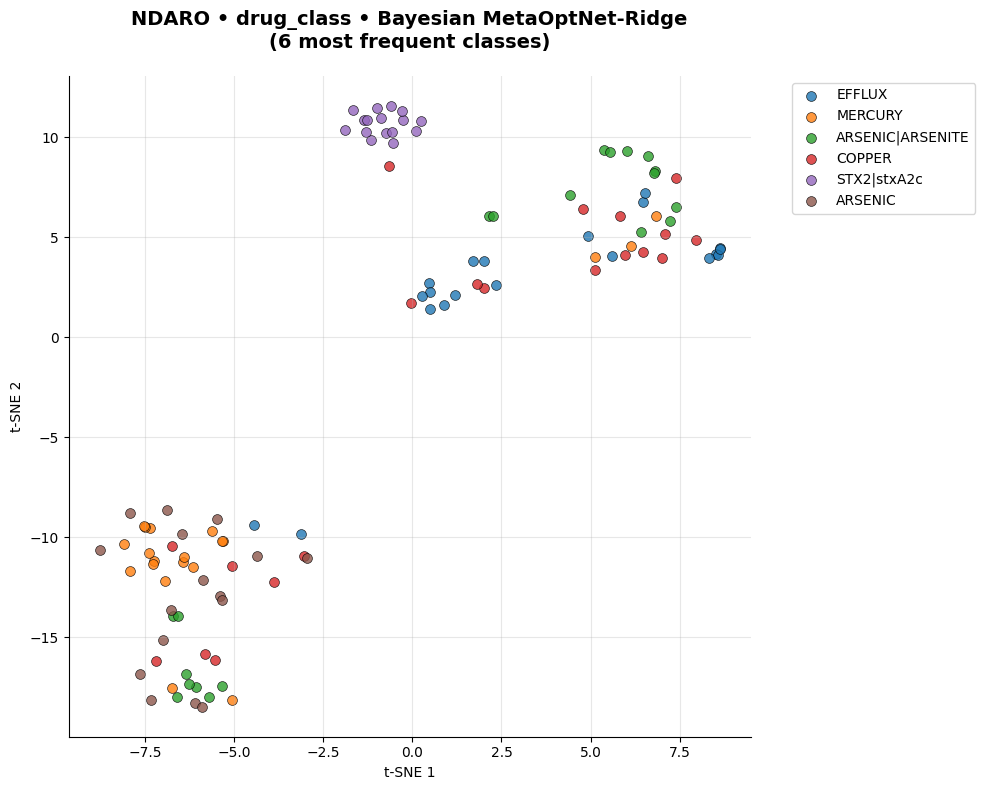

Created clean t-SNE with 112 sequences
Classes: ['EFFLUX', 'MERCURY', 'ARSENIC|ARSENITE', 'COPPER', 'STX2|stxA2c', 'ARSENIC']

Creating clean amr_gene_family t-SNE...


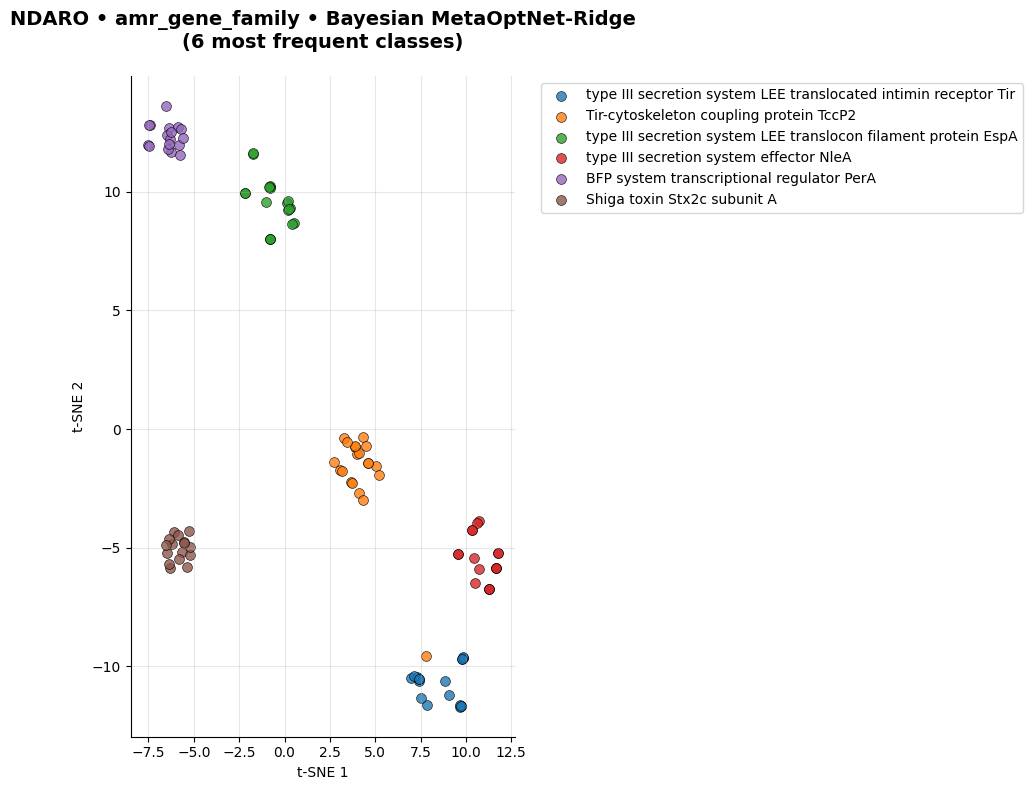

Created clean t-SNE with 109 sequences
Classes: ['type III secretion system LEE translocated intimin receptor Tir', 'Tir-cytoskeleton coupling protein TccP2', 'type III secretion system LEE translocon filament protein EspA', 'type III secretion system effector NleA', 'BFP system transcriptional regulator PerA', 'Shiga toxin Stx2c subunit A']
✓ Clean, simple t-SNE plots created!
✓ Only showing 6 most frequent classes
✓ Even sampling for balanced visualization
✓ No overlapping clutter


In [36]:
# Cell 22: Clean t-SNE with selected well-separated classes
print("Creating clean t-SNE with selected classes...")

def create_clean_tsne(encoder, df, label_col, top_n_classes=6, n_samples=150):
    """Create a clean t-SNE plot with only the most frequent classes"""

    # Get top N most frequent classes
    top_classes = df[label_col].value_counts().head(top_n_classes).index
    filtered_df = df[df[label_col].isin(top_classes)].copy()

    # Sample evenly from each class
    samples_per_class = n_samples // top_n_classes
    sampled_dfs = []
    for cls in top_classes:
        cls_df = filtered_df[filtered_df[label_col] == cls]
        if len(cls_df) > samples_per_class:
            sampled_dfs.append(cls_df.sample(samples_per_class, random_state=RANDOM_SEED))
        else:
            sampled_dfs.append(cls_df)

    clean_df = pd.concat(sampled_dfs, ignore_index=True)

    # Get embeddings
    ids = [encode_ids(s, KMER_K) for s in clean_df["sequence"].tolist()]
    tok = np.full((len(ids), MAX_LEN), stoi[PAD], dtype=np.int64)
    for i, seq in enumerate(ids):
        tok[i, :len(seq)] = seq[:MAX_LEN]

    nums = clean_df[["gc_content", "seq_len"]].to_numpy(np.float32)
    nums_std = (nums - num_mean) / num_std

    with torch.no_grad():
        Xt = torch.from_numpy(tok).long().to(device)
        Xn = torch.from_numpy(nums_std).float().to(device)
        embeddings = encoder(Xt, Xn).cpu().numpy()

    labels = clean_df[label_col].values

    # t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=20)
    reduced = tsne.fit_transform(embeddings)

    # Clean plot
    plt.figure(figsize=(10, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for i, cls in enumerate(top_classes):
        mask = labels == cls
        plt.scatter(reduced[mask, 0], reduced[mask, 1],
                   color=colors[i % len(colors)],
                   label=cls, s=50, alpha=0.8, edgecolors='black', linewidth=0.5)

    plt.title(f'NDARO • {label_col} • Bayesian MetaOptNet-Ridge\n({top_n_classes} most frequent classes)',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(f"Created clean t-SNE with {len(clean_df)} sequences")
    print(f"Classes: {list(top_classes)}")

# Create clean plots
print("Creating clean drug_class t-SNE...")
create_clean_tsne(encoder, ndaro_df, 'drug_class', top_n_classes=6, n_samples=120)

print("\nCreating clean amr_gene_family t-SNE...")
create_clean_tsne(encoder, ndaro_df, 'amr_gene_family', top_n_classes=6, n_samples=120)

print("✓ Clean, simple t-SNE plots created!")
print("✓ Only showing 6 most frequent classes")
print("✓ Even sampling for balanced visualization")
print("✓ No overlapping clutter")